<a href="https://colab.research.google.com/github/SyedAfzalHussain/CatvsDog-Detection-Machine-learning/blob/master/CatvsDogDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries are loaded successfully


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import os

# ... rest of your code ...

train_files = os.listdir('/content/drive/MyDrive/CatvsDog/train')  # Get file names

class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]



batch_size=32

train_transforms=transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])


# Corrected variable name: train_files
cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]


cats=CatDogDataset(cat_files, '/content/drive/MyDrive/CatvsDog/train', transform=train_transforms)

dogs=CatDogDataset(dog_files, '/content/drive/MyDrive/CatvsDog/train', transform=train_transforms)

catdogs=ConcatDataset([cats, dogs])

dataloader=DataLoader(catdogs, batch_size, shuffle=True, num_workers=4)
print("done")

done


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


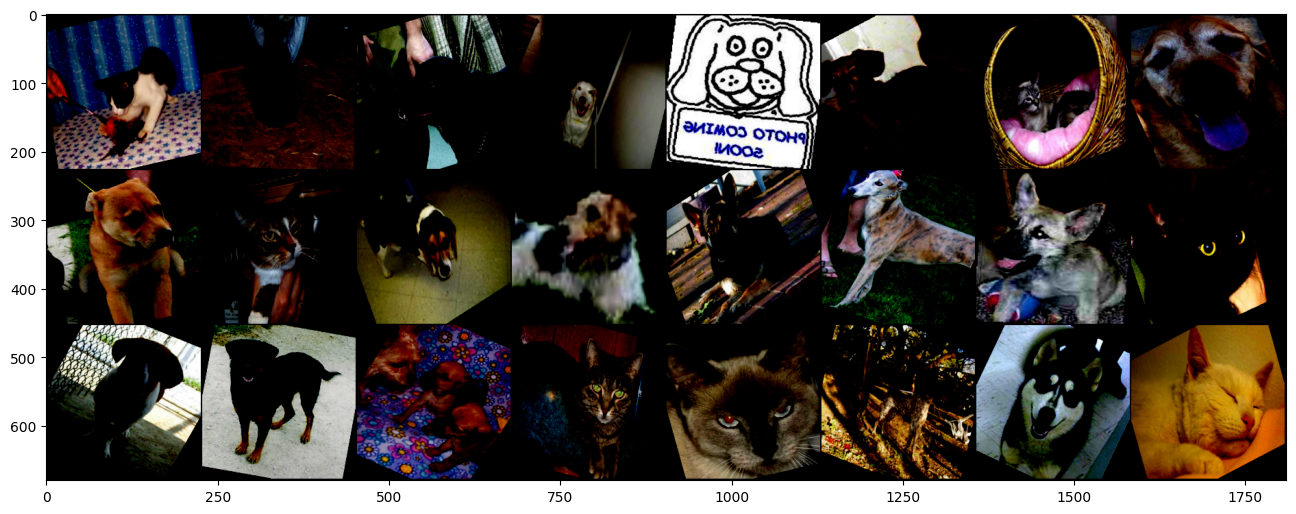

In [3]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(dataloader))
plt.figure(figsize=(16,24))
grid_imgs=torchvision.utils.make_grid(images[:24])
np_grid_imgs=grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [4]:
import torch
import torch.nn as nn

torch.backends.cudnn.deterministic=True

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()

        # define convolutional layers

        self.conv1=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2=nn.ReLU()
        # Since the pooling layer halves the size, the input image width and height must be divisible by 4 to avoid information loss during pooling. So our image should 224x224
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        # Define fully connected layers
        self.fc1=nn.Linear(128*56*56,512) #Adjust the input size based on the image dimensions
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(512,2) # 2 output

    def forward(self, x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.pool1(out)

        out=self.conv2(out)
        out=self.relu2(out)
        out=self.pool2(out)
        out=out.view(out.size(0), -1) # flatten the output

        out=self.fc1(out)
        out=self.relu3(out)
        out=self.fc2(out)
        return out

classifier=ImageClassifier()

classifier = ImageClassifier()

# Check for CUDA availability and use CPU if not available
if torch.cuda.is_available():
    device = 'cuda'
    classifier.to(device)
else:
    device = 'cpu'
    print("CUDA not detected. Using CPU.")

classifier.to(device)
print("done")

CUDA not detected. Using CPU.
done


Epoch 1
-------------------
Batch 0 -> loss: 0.691860 [    0/ 6002], Accuracy: 0.531250
Batch 100 -> loss: 8.485785 [ 3200/ 6002], Accuracy: 0.593750
Testing Score:
 Accuracy: 50.0%, Avg loss: 0.338476

Epoch 2
-------------------
Batch 0 -> loss: 11.369172 [    0/ 6002], Accuracy: 0.500000
Batch 100 -> loss: 0.697169 [ 3200/ 6002], Accuracy: 0.500000
Testing Score:
 Accuracy: 54.0%, Avg loss: 0.021619

Epoch 3
-------------------
Batch 0 -> loss: 0.687990 [    0/ 6002], Accuracy: 0.531250
Batch 100 -> loss: 0.752269 [ 3200/ 6002], Accuracy: 0.468750
Testing Score:
 Accuracy: 52.6%, Avg loss: 0.023876

Epoch 4
-------------------
Batch 0 -> loss: 0.869778 [    0/ 6002], Accuracy: 0.375000
Batch 100 -> loss: 0.691939 [ 3200/ 6002], Accuracy: 0.531250
Testing Score:
 Accuracy: 52.2%, Avg loss: 0.021728

Epoch 5
-------------------
Batch 0 -> loss: 0.713850 [    0/ 6002], Accuracy: 0.531250
Batch 100 -> loss: 0.719186 [ 3200/ 6002], Accuracy: 0.500000
Testing Score:
 Accuracy: 54.7%, Avg 

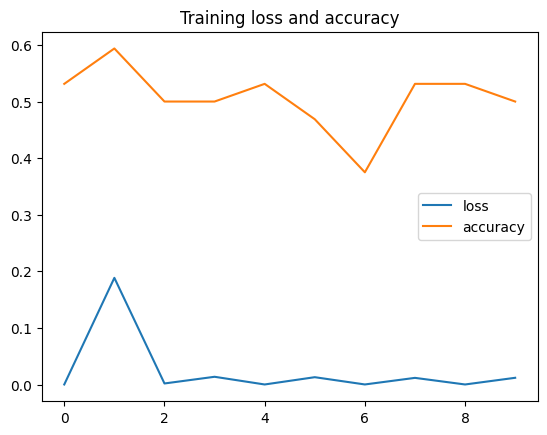

In [5]:
model = ImageClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define optimizer outside
loss_fn = nn.CrossEntropyLoss()

def train_func(dataloader, model, loss_fn, optimizer, scheduler):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    total_loss=0
    size=len(dataloader.dataset)
    model.train()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device), y.to(device)

        # compute prediction error
        pred=model(X)
        loss=loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        scheduler.step()

        if batch %100==0:
            p=torch.argmax(pred, dim=1)
            correct=p.eq(y)
            acc=torch.mean(correct.float()).cpu()
            loss,current=loss.item(), batch*len(X)

            print(f'Batch {batch} -> loss: {loss:>7f} [{current:>5d}/{size:>5d}], Accuracy: {acc:>3f}')
            loss_list.append(total_loss/size)
            acc_list.append(acc)


def test_func(dataloader, model, scheduler):
    size=len(dataloader.dataset)
    model.eval()
    test_loss, correct=0,0
    with torch.no_grad():
        for X, y in dataloader:
            X,y =X.to(device), y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=size
    correct /=size
    print(f'Testing Score:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n')

epochs=5
loss_list=[]
acc_list=[]

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Example scheduler

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------')
    train_func(dataloader, classifier, loss_fn, optimizer, scheduler)
    test_func(dataloader, classifier, scheduler)
    # test_func(dataloader, classifier)
print("Done")

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('Training loss and accuracy')
plt.show()

In [7]:
torch.save(classifier.state_dict(), "/content/drive/MyDrive/CatvsDog/image_classifier_v01.pth")

In [8]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image


In [15]:
img_path = "/content/drive/MyDrive/CatvsDog/test1/1000.jpg"  # Replace with your image path
img = Image.open(img_path)


In [28]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image

# Define the same model architecture as your trained model
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()

        # define convolutional layers

        self.conv1=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2=nn.ReLU()
        # Since the pooling layer halves the size, the input image width and height must be divisible by 4 to avoid information loss during pooling. So our image should 224x224
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        # Define fully connected layers
        self.fc1=nn.Linear(128*56*56,512) #Adjust the input size based on the image dimensions
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(512,2) # 2 output

    def forward(self, x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.pool1(out)

        out=self.conv2(out)
        out=self.relu2(out)
        out=self.pool2(out)
        out=out.view(out.size(0), -1) # flatten the output

        out=self.fc1(out)
        out=self.relu3(out)
        out=self.fc2(out)
        return out


# Load the saved model state dictionary
model = ImageClassifier()
model.load_state_dict(torch.load("/content/drive/MyDrive/CatvsDog/image_classifier_v01.pth"))

# Define image preprocessing steps (ensure they match training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Assuming normalization used in training
])

# Load your test image
img_path = "/content/drive/MyDrive/CatvsDog/test1/1003.jpg"  # Replace with your image path
img = Image.open(img_path)

resized_img = img.resize((224, 224))
# Apply preprocessing
img = transform(resized_img).unsqueeze(0)  # Add a batch dimension for the model

# Move data to GPU (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = img.to(device)

# Set model to evaluation mode (optional for some models)
model.eval()

# Get prediction
with torch.no_grad():
    output = model(img)
    prediction = torch.argmax(output, dim=1).item()

# Get class labels (assuming you have a list of class labels)
class_labels = ["cat", "dog"]  # Replace with your actual class labels
print(f"Predicted class: {class_labels[prediction]}")


Predicted class: dog
